## CS6700: Reinforcement Learning - Tutorial 4 (Q-Learning and SARSA)

Your tasks are as follows:

1. Complete code for $\epsilon$-greedy and softmax action selection policy
2. Complete update equation for SARSA - train and visualize an agent
3. Analyze performance of SARSA - Plot total reward & steps taken per episode (averaged across 5 runs)
4. Complete update equation for Q-Learning - train and visualize an agent
5. Analyze performance of Q-Learning - Plot total reward & steps taken per episode (averaged across 5 runs)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import random
import decimal
import operator
%matplotlib inline

# Problem Statement

In this section we will implement tabular SARSA and Q-learning algorithms for a grid world navigation task.

## Environment details
The agent can move from one grid coordinate to one of its adjacent grids using one of the four actions: UP, DOWN, LEFT and RIGHT. The goal is to go from a randomly assigned starting position to goal position.

Actions that can result in taking the agent off the grid will not yield any effect.
Lets look at the environment.


In [26]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

Let us construct a grid in a text file.

In [27]:
!cat grid_world2.txt

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
1 1 1 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 2 2 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


This is a $17\times 23$ grid. The reward when an agent goes to a cell is negative of the value in that position in the text file (except if it is the goal cell). We will define the goal reward as 100. We will also fix the maximum episode length to 10000.

Now let's make it more difficult. We add stochasticity to the environment: with probability 0.2 agent takes a random action (which can be other than the chosen action).
There is also a westerly wind blowing (to the right). Hence, after every time-step, with probability 0.5 the agent also moves an extra step to the right.

Now let's plot the grid world.

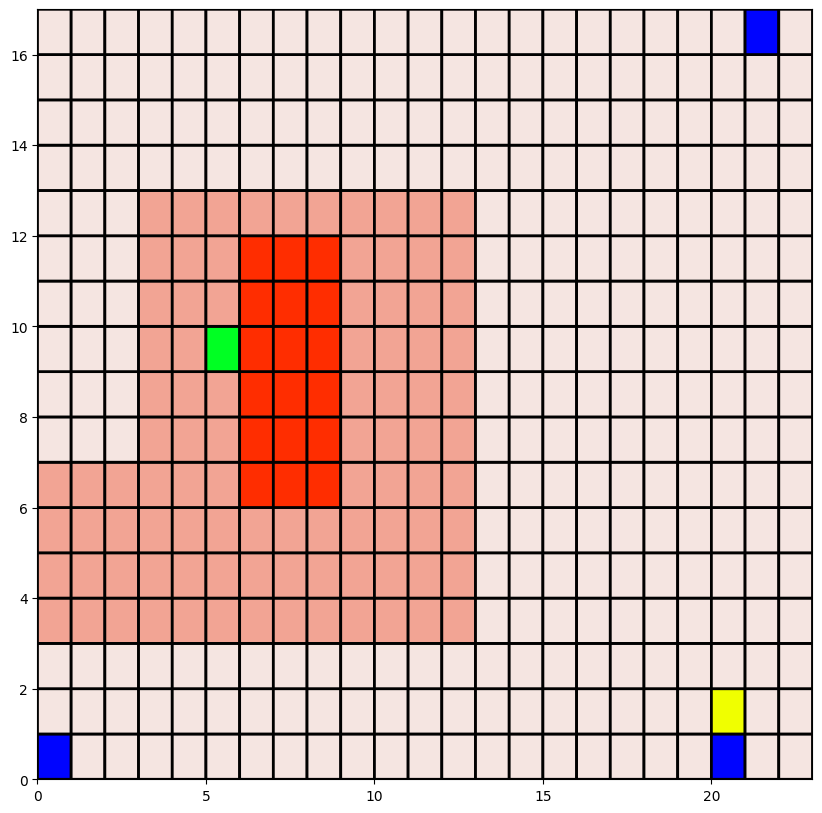

In [28]:
world = 'grid_world2.txt'
goal_reward = 100
start_states = [(0,0), (0,20), (16,21)]
goal_states=[(9,5)]
max_steps=10000

from grid_world import GridWorldEnv, GridWorldWindyEnv

env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps, action_fail_prob=0.2)
plt.figure(figsize=(10, 10))
# Go UP
env.step(UP)
env.render(ax=plt, render_agent=True)

### Legend
- <span style="color:#0004FF">*Blue*</span> is the **start state**.
- <span style="color:#00FF23">*Green*</span> is the **goal state**.
- <span style="color:#F0FF00">*Yellow*</span> is current **state of the agent**.
- <span style="color:#FF2D00">*Redness*</span> denotes the extent of **negative reward**.

### Q values
We can use a 3D array to represent Q values. The first two indices are X, Y coordinates and last index is the action.

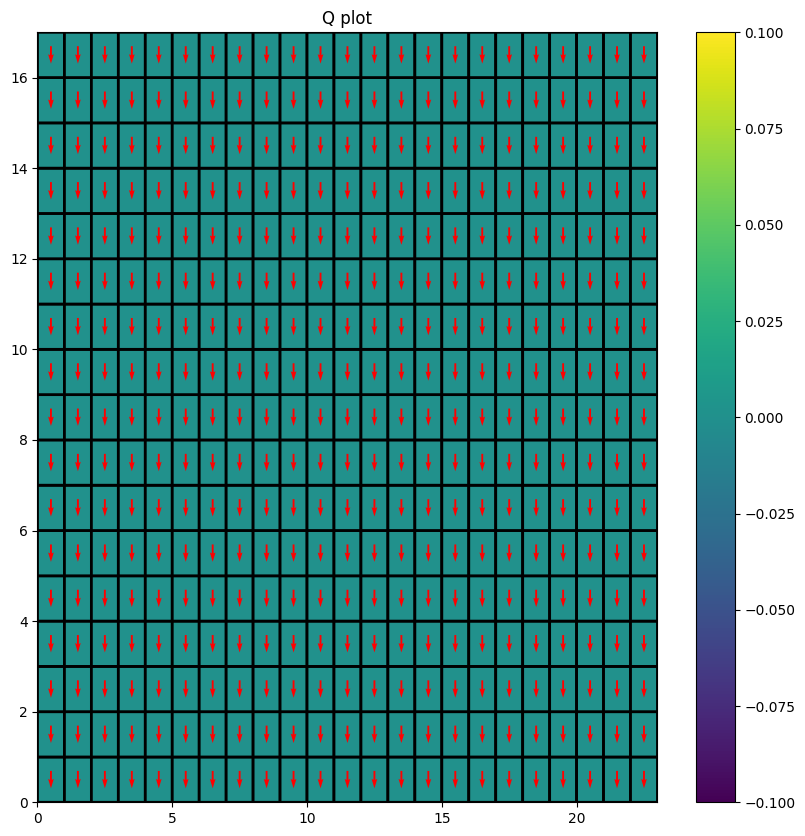

(17, 23, 4)

In [29]:
from grid_world import plot_Q

Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

plot_Q(Q)

Q.shape

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [30]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon = 0.1 , rg=rg):

     if rg.rand()<epsilon: # TODO: eps greedy condition
        return rg.randint(len(actions))# TODO: return random action
     else:
        return actions[np.argmax(Q[state[0]][state[1]])]# TODO: return best action


# Softmax
def choose_action_softmax(Q, state, rg=rg):
    P = {id : decimal.Decimal(2.718)**(decimal.Decimal(Q[state[0],state[1],id])) for id in actions}
    deno = sum(P.values())
    Probability = {id : P[id]/deno for id in P.keys()}
    Probability = dict(sorted(Probability.items(), key=operator.itemgetter(1)))
    r =  rg.rand()
    cumsum = 0
    for k in Probability.keys():
      cumsum = cumsum + Probability[k]
      if cumsum > r:
        return k

    return k # TODO: return random action with selection probability

## SARSA
Now we implement the SARSA algorithm.

Recall the update rule for SARSA:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
\end{equation}

### Hyperparameters

So we have som hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

In [31]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

Let's implement SARSA

In [32]:
print_freq = 100

def sarsa(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)

            # TODO: update equation
            Q[state[0],state[1],action] += alpha*(reward + gamma*(Q[state_next[0],state_next[1],action_next]) - Q[state[0],state[1],action])
            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion

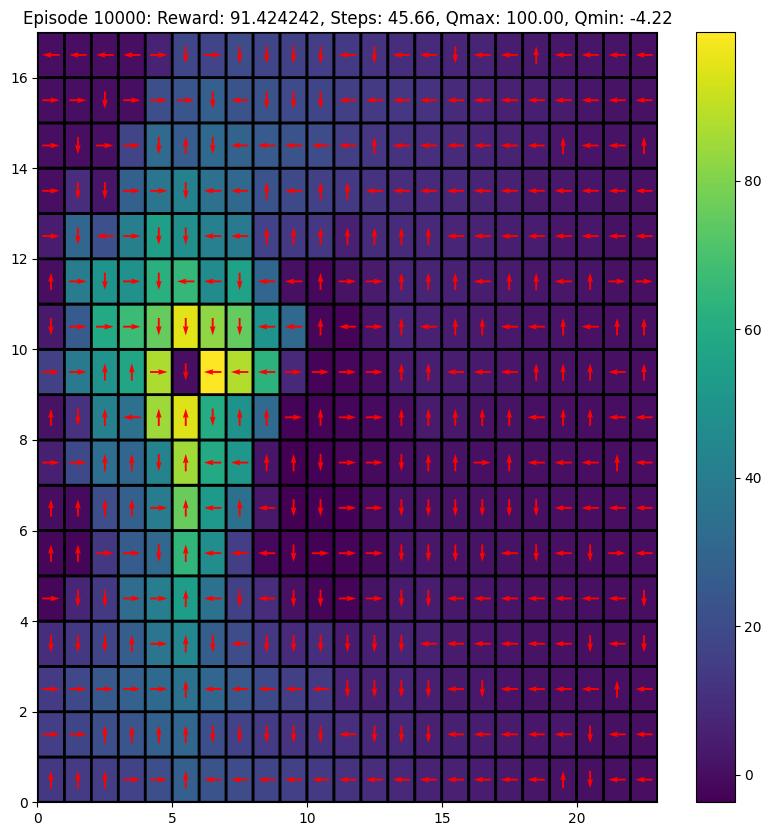

100%|██████████| 10000/10000 [09:56<00:00, 16.77it/s]


In [33]:
Q, rewards, steps = sarsa(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

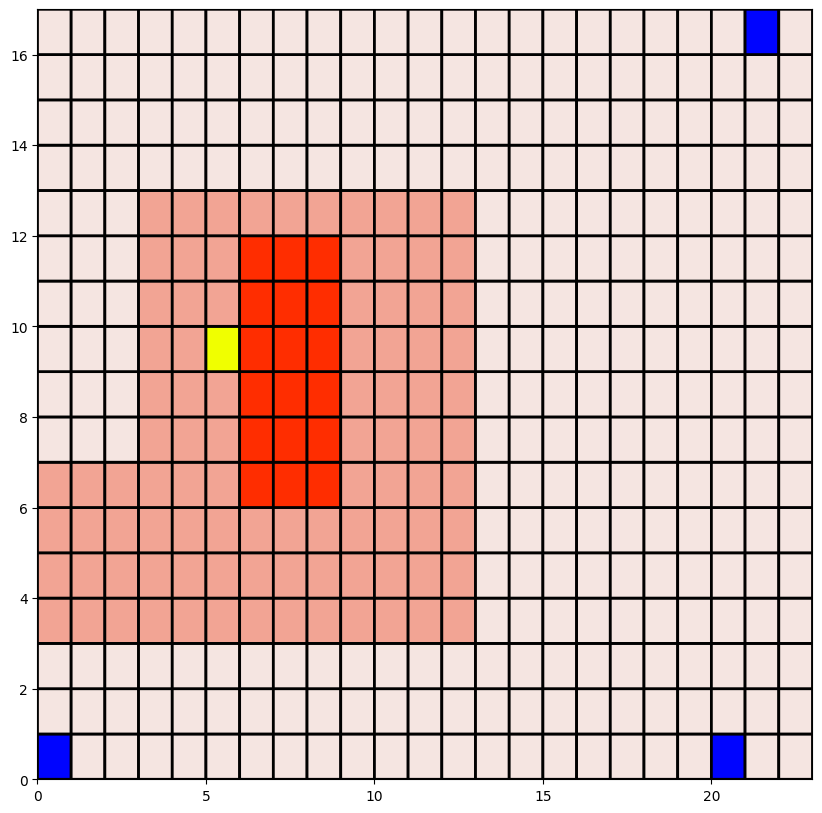

Steps: 43, Total Reward: 94


In [34]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy
We use two metrics to analyze the policies:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

In [35]:
num_expts = 5
reward_avgs, steps_avgs = [0 for i in range(10000)], [0 for i in range(10000)]

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    Q_s, reward_s, step_s = sarsa(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
    reward_avgs =  [x + y for x, y in zip(reward_s, reward_avgs)]
    steps_avgs =  [x + y for x, y in zip(step_s, steps_avgs)]



reward_avgs = [x/num_expts for x in reward_avgs]
steps_avgs = [x/num_expts for x in steps_avgs]

    # TODO: run sarsa, store metrics

Experiment: 1


100%|██████████| 10000/10000 [07:53<00:00, 21.14it/s]


Experiment: 2


100%|██████████| 10000/10000 [07:20<00:00, 22.70it/s]


Experiment: 3


100%|██████████| 10000/10000 [09:30<00:00, 17.54it/s]


Experiment: 4


100%|██████████| 10000/10000 [09:35<00:00, 17.38it/s]


Experiment: 5


100%|██████████| 10000/10000 [07:49<00:00, 21.30it/s]


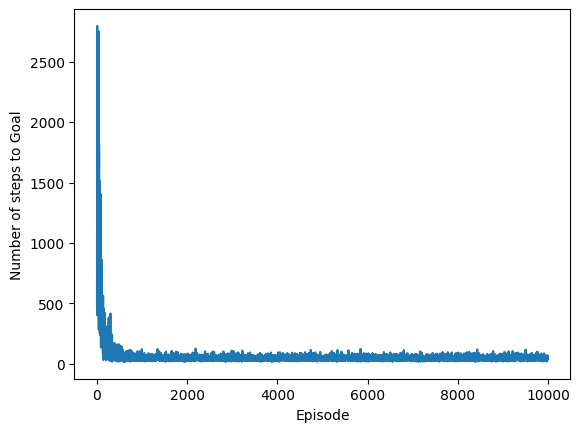

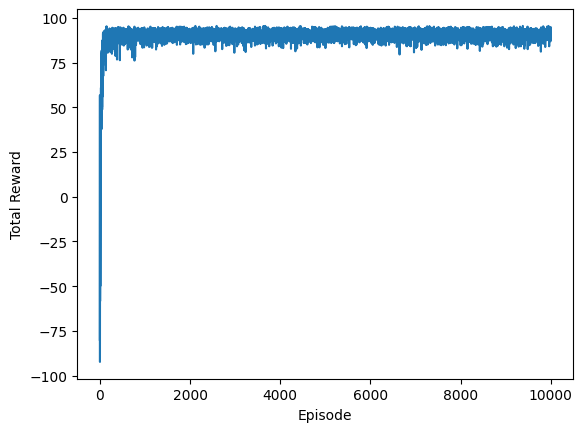

In [36]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))

plt.figure()
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
episode_count = np.arange(0, 10000)
plt.plot(episode_count, steps_avgs)
plt.show()

plt.figure()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(episode_count, reward_avgs)
plt.show()

## Q-Learning
Now, implement the Q-Learning algorithm as an exercise.

Recall the update rule for Q-Learning:
\begin{equation}
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]
\end{equation}

Visualize and compare results with SARSA.

In [37]:
# initialize Q-value
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))

alpha0 = 0.4
gamma = 0.9
episodes = 10000
epsilon0 = 0.1

In [38]:
print_freq = 100

def qlearning(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(Q, state)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next)

            # TODO: update equation
            act_max = np.argmax(Q[state_next[0],state_next[1]])
            Q[state[0],state[1],action] += alpha*(reward + gamma*(Q[state_next[0],state_next[1],act_max]) - Q[state[0],state[1],action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion

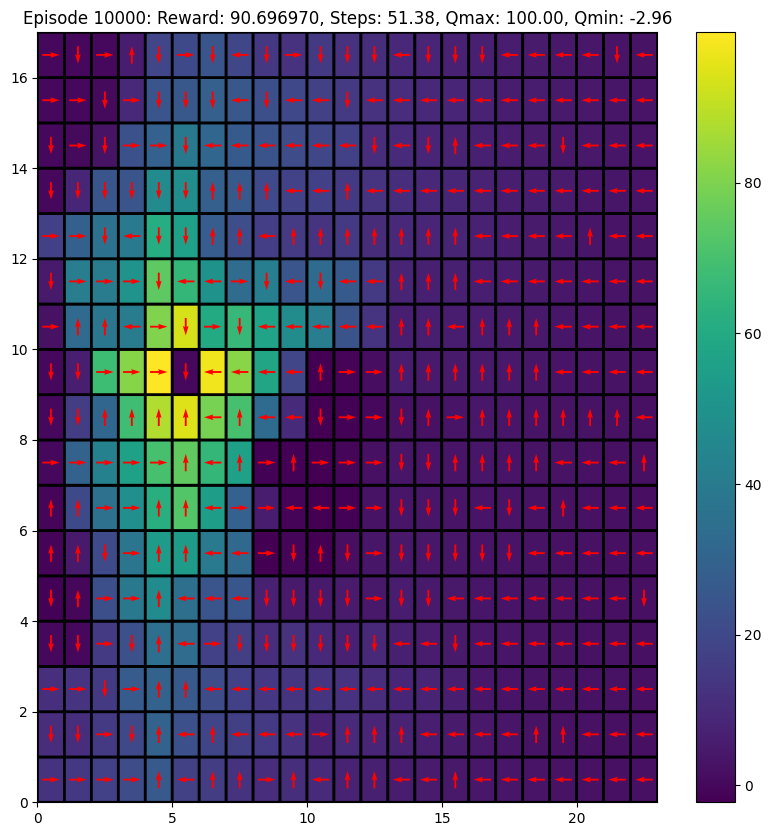

100%|██████████| 10000/10000 [10:29<00:00, 15.87it/s]


In [39]:
Q, rewards, steps = qlearning(env, Q, gamma = gamma, plot_heat=True, choose_action= choose_action_softmax)

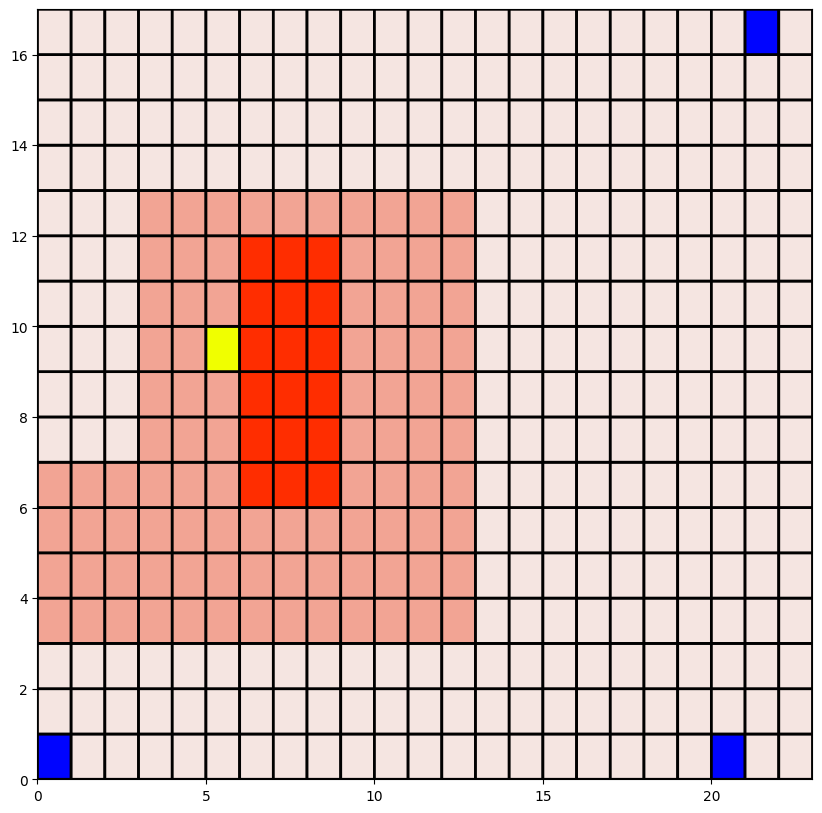

Steps: 16, Total Reward: 93


In [40]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    state, reward, done = env.step(Q[state[0], state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

In [41]:
num_expts = 5
reward_avgs, steps_avgs = [0 for i in range(10000)], [0 for i in range(10000)]

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
    rg = np.random.RandomState(i)
    Q_s, reward_s, step_s = qlearning(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax)
    reward_avgs =  [x + y for x, y in zip(reward_s, reward_avgs)]
    steps_avgs =  [x + y for x, y in zip(step_s, steps_avgs)]



reward_avgs = [x/num_expts for x in reward_avgs]
steps_avgs = [x/num_expts for x in steps_avgs]


    # TODO: run qlearning, store metrics

Experiment: 1


100%|██████████| 10000/10000 [07:36<00:00, 21.93it/s]


Experiment: 2


100%|██████████| 10000/10000 [09:07<00:00, 18.27it/s]


Experiment: 3


100%|██████████| 10000/10000 [08:57<00:00, 18.62it/s]


Experiment: 4


100%|██████████| 10000/10000 [12:37<00:00, 13.19it/s]


Experiment: 5


100%|██████████| 10000/10000 [08:05<00:00, 20.61it/s]


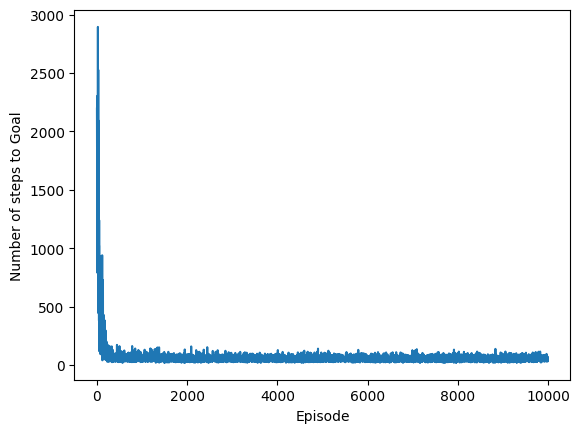

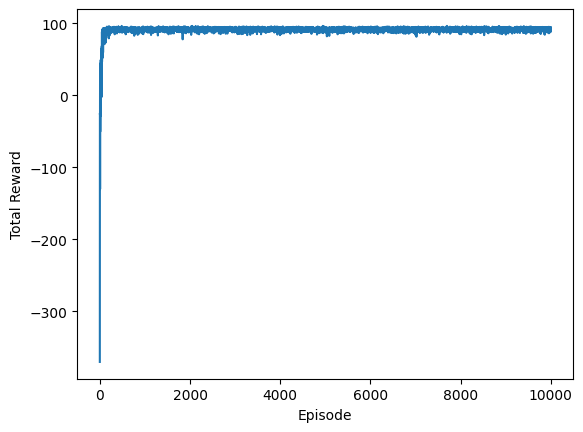

In [42]:
# TODO: visualize individual metrics vs episode count (averaged across multiple run(s))
plt.figure()
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
episode_count = np.arange(0, 10000)
plt.plot(episode_count, steps_avgs)
plt.show()

plt.figure()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(episode_count, reward_avgs)
plt.show()

### TODO: What differences do you observe between the policies learnt by Q Learning and SARSA (if any).

Q learning is more focussed on exploitation (being off policy), than sarsa ( on policy). So it takes actions which at times are not really probable according to sarsa, but they might have potential to be the optimal action. Sarsa is a more conservative, as it learns from the policy.

###From the plots, it is also evident that Q Learning reached closer to optimal policy and max reward faster than Sarsa. This is an other influence of Q learning providing more exporation.

Finally both Sarsa and Q learning at 10000 episodes provide similar reward values - around 90, and similar number of steps to reach goal


###Inference:

epsilon greedy - for the given hyperparameters, didnt go well, it wasnt able to reach the goal and learn the optimal path within 10000, it seems to be that we could go with a better combination of hyperparameters, and we could in steps, decrease the value of epsilon as the agent learns with time

I tried changing the hyperparameter epsilon and checked that, it was still random, at times the reward was higher , and other times it was lower as low as 0.1, 10, etc, and I believe that this was basically due to the fact that the 100000 episodes are less for epsilon greedy to learn, it needs more episodes to find the optimal path. For instance, for an epsilon of 0.15, the total reward was 26 for Sarsa and around 42 for Qlearning. Q learning showed better results with epsilon greedy than Sarsa results with epsilon greedy
I tried to iterate over different hyperparameters, but due to time constraints as the epsilon greedy took too much time, the best epsilon i could find so far is 0.15.
And this again means that 15% the agent behaves randomly, which is still a lot of randomness and we need more episiodes and we need to slowly decrease the epsilon value with time for better learning.


In [43]:
!pip install nbconvert
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [48]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Anirud_CE21B014_CS6700_Tutorial_4_QLearning_SARSA.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Anirud_CE21B014_CS6700_Tutorial_4_QLearning_SARSA.ipynb to html
[NbConvertApp] Writing 1329446 bytes to /content/drive/MyDrive/Anirud_CE21B014_CS6700_Tutorial_4_QLearning_SARSA.html


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
